# Proyecto Final

# Datos de SINAICA. 

In [1]:
import os, gzip, json, re, stan, dplython, asyncio, nest_asyncio
#nest_asyncio.apply()
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)
from dplython import (DplyFrame, X, diamonds, select, sift,
  sample_n, sample_frac, head, arrange, mutate, group_by,
  summarize, DelayFunction, dfilter)
import seaborn as sns
from plotnine import *
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, 
                             r2_score,
                             mean_absolute_error)
import pandas as pd
from IPython.display import display, Markdown

/home/jaa6766/.conda/envs/cuda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
/home/jaa6766/.conda/envs/cuda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
/home/jaa6766/.conda/envs/cuda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
/home/jaa6766/.conda/envs/cuda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [2]:
base_dir = "data/sinaica/" 
data_dir = os.path.join(
    os.getcwd(),
    base_dir
)

#df = pd.read_pickle("data/airdata/air.pickle")

display(Markdown(f"Listing data files from: {data_dir}..."))

generator = (file for file in os.listdir(data_dir) 
             if (re.match(r"Datos SINAICA - [-A-ZáéíóúÁÉÍÓÚa-z0-9. ]{30,80}\.csv", file) is not None))
sinaica = pd.read_pickle("data/sinaica.pickle")
for (j, file_csv) in enumerate(generator):
    #display(Markdown(f"{i+1}. File \"{file_csv}\""))

    try:
        station, sensor = re.match(
            r"Datos SINAICA - ([A-ZáéíóúÁÉÍÓÚa-z. ]{3,20}) - ([A-Z0-9a-z.]+) - [-0-9 ]+\.csv", 
             file_csv).groups()
        #display(Markdown(f"   * {station}, {sensor}"))
        df2 = pd.read_csv(os.path.join(data_dir, file_csv))
        df2 = df2.assign(Estacion=station)
        sinaica = pd.concat([sinaica, df2])
        #display(df2.head(3))
        sinaica = sinaica.sort_values(by=["Fecha", "Estacion", "Parámetro"])
        sinaica["Hora"] = sinaica[["Hora"]].replace("- .*$", "", regex=True)
        sinaica["Fecha"] = pd.to_datetime(sinaica["Fecha"] + " " + sinaica["Hora"])
        #sinaica.drop("Hora", axis=1, inplace=True)
        sinaica = sinaica[(sinaica["Fecha"] >= "2021-01-01")].copy()
        display(Markdown(f"Done reading {j+1} files!"))
        display(pd.concat([sinaica.head(5), sinaica.tail(5)]))
    except Exception as e:
        print(f"Error while reading file {file_csv}", type(e))
        raise e


Listing data files from: /home/jaa6766/Documents/jorge3a/itam/deeplearning/dlfinal/data/sinaica/...

### Visualización de las Estaciones Cercanas

Encontramos que las siguientes son algunas de las estaciones cercanas a "Camarones" que está próxima a nuestro sensor:

![Mapa de Estaciones Cercanas](img/mapa.jpg)

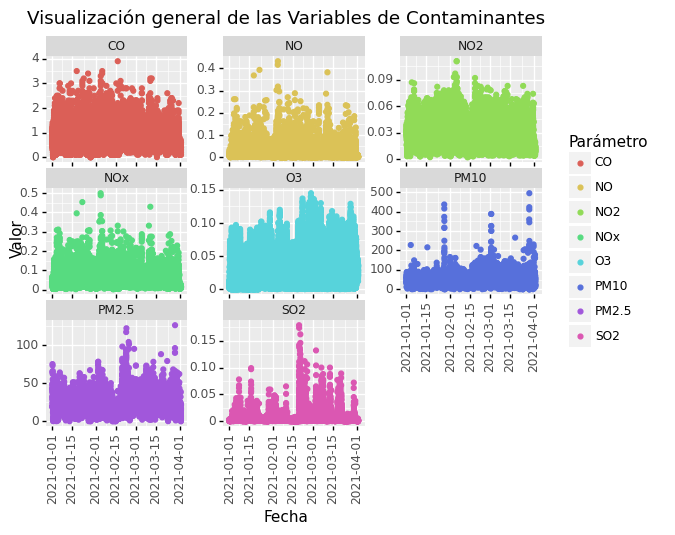

<ggplot: (8727197776273)>

In [3]:
(
    ggplot(sinaica) +
    geom_point(aes(x="Fecha", y="Valor", color="Parámetro")) +
    facet_wrap("Parámetro", scales="free") +
    labs(title="Visualización general de las Variables de Contaminantes") +
    theme(axis_text_x=element_text(angle=90),
          subplots_adjust={'wspace': 0.25, 'hspace': 0.25}
         )
)

### Estación de Monitoreo Camarones

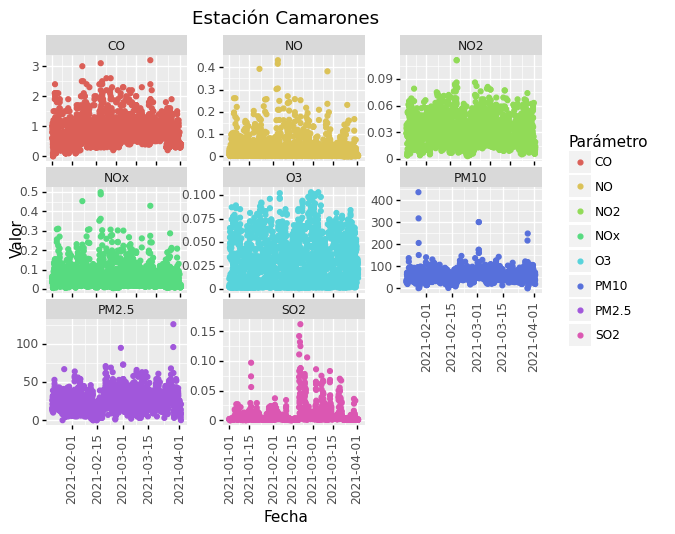

<ggplot: (8727144135101)>

In [4]:
(
    ggplot(sinaica[(sinaica["Estacion"] == "Camarones")]) + 
    geom_point(aes(x="Fecha", y="Valor", color="Parámetro")) +
    facet_wrap("Parámetro", scales="free") +
    labs(title="Estación Camarones") + 
    theme(axis_text_x=element_text(angle=90),
          subplots_adjust={'wspace': 0.25, 'hspace': 0.25}
         )
)

In [5]:
sinaica.to_pickle("data/sinaica/sinaica.pickle")

## Imputaciones: Datos Faltantes de las Estaciones de Monitoreo.

Algunos datos faltantes son causados por mantenimiento del equipo. Pero pudiéramos enriquecer la información con los datos de estaciones cercanas. Para ello vamos a evaluar las imputaciones.

In [6]:
dsinaica = DplyFrame(pd.read_pickle("data/sinaica/dsinaica.pickle"))
dsinaica

,Fecha,Camarones_CO,Camarones_NO,Camarones_NO2,Camarones_NOx,Camarones_O3,Camarones_PM10,Camarones_PM2.5,Camarones_SO2,FES Acatlán_CO,...,Miguel Hidalgo_O3,Miguel Hidalgo_SO2,Tlalnepantla_CO,Tlalnepantla_NO,Tlalnepantla_NO2,Tlalnepantla_NOx,Tlalnepantla_O3,Tlalnepantla_PM10,Tlalnepantla_PM2.5,Tlalnepantla_SO2
0,2021-01-01 00:00:00,0.6,0.006,0.029,0.034,0.011,NaN,NaN,0.002,0.4,...,0.009,0.003,0.6,NaN,0.030,0.034,0.012,37.0,19.0,0.002
1,2021-01-01 01:00:00,1.0,0.021,0.038,0.059,0.002,NaN,NaN,0.002,0.6,...,0.006,0.003,0.6,NaN,0.026,0.029,0.013,42.0,29.0,0.003
2,2021-01-01 02:00:00,0.8,0.013,0.035,0.049,0.003,NaN,NaN,0.001,0.9,...,0.003,0.002,0.7,NaN,0.032,0.036,0.006,58.0,43.0,0.002
3,2021-01-01 03:00:00,1.0,0.031,0.034,0.065,0.002,NaN,NaN,0.001,0.8,...,0.004,0.002,0.7,NaN,0.033,0.039,0.004,59.0,41.0,0.002
4,2021-01-01 04:00:00,0.6,0.005,0.029,0.034,0.005,NaN,NaN,0.001,1.0,...,0.006,0.002,0.7,NaN,0.032,0.038,0.004,64.0,46.0,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2166,2021-04-01 19:00:00,0.4,0.003,0.011,0.013,0.016,69.0,7.0,0.001,0.3,...,0.023,0.000,0.3,0.009,0.017,0.025,0.017,52.0,24.0,0.003
2167,2021-04-01 20:00:00,0.4,0.002,0.011,0.012,0.018,71.0,9.0,0.001,0.2,...,0.024,0.000,0.4,0.004,0.015,0.019,0.020,22.0,10.0,0.005
2168,2021-04-01 21:00:00,0.4,0.002,0.013,0.015,0.016,37.0,9.0,0.001,0.2,...,0.023,0.000,0.3,0.002,0.014,0.017,0.021,21.0,14.0,0.002
2169,2021-04-01 22:00:00,0.4,0.002,0.019,0.021,0.012,19.0,0.0,0.001,0.1,...,0.027,0.000,0.3,0.002,0.011,0.013,0.022,11.0,7.0,0.001


In [7]:
dsinaica[dsinaica.isna().any(axis=1)]

,Fecha,Camarones_CO,Camarones_NO,Camarones_NO2,Camarones_NOx,Camarones_O3,Camarones_PM10,Camarones_PM2.5,Camarones_SO2,FES Acatlán_CO,...,Miguel Hidalgo_O3,Miguel Hidalgo_SO2,Tlalnepantla_CO,Tlalnepantla_NO,Tlalnepantla_NO2,Tlalnepantla_NOx,Tlalnepantla_O3,Tlalnepantla_PM10,Tlalnepantla_PM2.5,Tlalnepantla_SO2
0,2021-01-01 00:00:00,0.6,0.006,0.029,0.034,0.011,NaN,NaN,0.002,0.4,...,0.009,0.003,0.6,NaN,0.030,0.034,0.012,37.0,19.0,0.002
1,2021-01-01 01:00:00,1.0,0.021,0.038,0.059,0.002,NaN,NaN,0.002,0.6,...,0.006,0.003,0.6,NaN,0.026,0.029,0.013,42.0,29.0,0.003
2,2021-01-01 02:00:00,0.8,0.013,0.035,0.049,0.003,NaN,NaN,0.001,0.9,...,0.003,0.002,0.7,NaN,0.032,0.036,0.006,58.0,43.0,0.002
3,2021-01-01 03:00:00,1.0,0.031,0.034,0.065,0.002,NaN,NaN,0.001,0.8,...,0.004,0.002,0.7,NaN,0.033,0.039,0.004,59.0,41.0,0.002
4,2021-01-01 04:00:00,0.6,0.005,0.029,0.034,0.005,NaN,NaN,0.001,1.0,...,0.006,0.002,0.7,NaN,0.032,0.038,0.004,64.0,46.0,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,2021-03-31 13:00:00,0.4,0.004,0.017,0.020,0.053,96.0,23.0,0.002,NaN,...,0.075,0.001,0.5,0.010,0.018,0.028,0.062,64.0,37.0,0.002
2144,2021-03-31 21:00:00,0.4,0.002,0.019,0.021,0.021,42.0,13.0,0.001,0.3,...,NaN,NaN,0.4,0.004,0.018,0.022,0.025,112.0,43.0,0.003
2146,2021-03-31 23:00:00,0.8,0.013,0.063,0.076,0.007,69.0,26.0,0.002,0.6,...,0.043,0.001,0.6,0.002,0.042,0.044,0.023,41.0,24.0,0.002
2164,2021-04-01 17:00:00,0.4,0.003,0.009,0.012,0.022,42.0,14.0,0.001,0.2,...,0.031,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Datos Faltantes en Estación Camarones 

Observamos que en la estación Camarones, que es la más cercana, todos los indicadores tienen valores faltantes.

In [8]:
camarones = dsinaica[dsinaica.filter(like="Camarones").isna().any(axis=1)].filter(like="Camarones")
camarones

,Camarones_CO,Camarones_NO,Camarones_NO2,Camarones_NOx,Camarones_O3,Camarones_PM10,Camarones_PM2.5,Camarones_SO2
0,0.6,0.006,0.029,0.034,0.011,NaN,NaN,0.002
1,1.0,0.021,0.038,0.059,0.002,NaN,NaN,0.002
2,0.8,0.013,0.035,0.049,0.003,NaN,NaN,0.001
3,1.0,0.031,0.034,0.065,0.002,NaN,NaN,0.001
4,0.6,0.005,0.029,0.034,0.005,NaN,NaN,0.001
...,...,...,...,...,...,...,...,...
2027,NaN,NaN,NaN,NaN,NaN,85.0,26.0,NaN
2028,NaN,NaN,NaN,NaN,NaN,67.0,22.0,NaN
2029,NaN,NaN,NaN,NaN,NaN,63.0,28.0,NaN
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
display(Markdown(f"De ahí que tengamos la idea de no perder una porción considerable: " +
                 f'{100*dsinaica[dsinaica.filter(like="Camarones").isna().any(axis=1)].filter(like="Camarones").shape[0]/dsinaica.shape[0]:.2f}%' +
                 f' mediante imputación. Vamos a evaluar los varios métodos con el fin de imputar de la manera más acertada.'
                ))

De ahí que tengamos la idea de no perder una porción considerable: 28.14% mediante imputación. Vamos a evaluar los varios métodos con el fin de imputar de la manera más acertada.

### Observaciones Completas en Estación Camarones

In [10]:
dsinaica[~dsinaica.filter(like="Camarones").isna().any(axis=1)].filter(like="Camarones")

,Camarones_CO,Camarones_NO,Camarones_NO2,Camarones_NOx,Camarones_O3,Camarones_PM10,Camarones_PM2.5,Camarones_SO2
479,0.5,0.021,0.024,0.046,0.002,30.0,14.0,0.008
480,0.6,0.017,0.023,0.039,0.002,28.0,16.0,0.006
481,0.5,0.023,0.022,0.046,0.002,38.0,26.0,0.005
482,0.6,0.030,0.021,0.051,0.002,35.0,21.0,0.003
483,0.8,0.057,0.022,0.079,0.002,26.0,12.0,0.003
...,...,...,...,...,...,...,...,...
2166,0.4,0.003,0.011,0.013,0.016,69.0,7.0,0.001
2167,0.4,0.002,0.011,0.012,0.018,71.0,9.0,0.001
2168,0.4,0.002,0.013,0.015,0.016,37.0,9.0,0.001
2169,0.4,0.002,0.019,0.021,0.012,19.0,0.0,0.001


### Separación en Sets de Pruebas y Entrenamiento

In [11]:
camarones_full = dsinaica[~dsinaica.filter(like="Camarones").isna().any(axis=1)]
camarones_train, camarones_test = train_test_split(camarones_full,
                                                   test_size=0.3, random_state=175904,
                                                   shuffle=False
                                                  )
camarones_val = dsinaica[dsinaica.filter(like="Camarones").isna().any(axis=1)]
display(Markdown(f"* Observaciones completas: {camarones_full.shape[0]} (100%)."))
display(Markdown(f">* Observaciones completas en el set de entrenamiento: {camarones_train.shape[0]} (~70%)."))
display(Markdown(f">* Observaciones completas en el set de pruebas: {camarones_test.shape[0]} (~30%)."))
display(Markdown(f"* Observaciones incompletas: {camarones_val.shape[0]}."))

* Observaciones completas: 1560 (100%).

>* Observaciones completas en el set de entrenamiento: 1092 (~70%).

>* Observaciones completas en el set de pruebas: 468 (~30%).

* Observaciones incompletas: 611.

### Distribución de Datos

#### PM10

Estas son las estaciones que miden el contaminante PM 10.

In [12]:
dsinaica[~dsinaica.filter(like="PM10").isna().any(axis=1)].filter(like="PM10")

,Camarones_PM10,FES Acatlán_PM10,Gustavo A. Madero_PM10,Merced_PM10,Tlalnepantla_PM10
479,30.0,15.0,33.0,34.0,32.0
480,28.0,11.0,32.0,29.0,24.0
481,38.0,15.0,28.0,33.0,41.0
482,35.0,15.0,25.0,32.0,20.0
483,26.0,15.0,31.0,27.0,19.0
...,...,...,...,...,...
2165,71.0,178.0,69.0,49.0,90.0
2166,69.0,162.0,33.0,36.0,52.0
2167,71.0,49.0,32.0,24.0,22.0
2169,19.0,14.0,19.0,21.0,11.0


In [13]:
def describe_with_na(dataframe):
    dna = dataframe.isna()
    dna = dna.astype('int').sum()
    dna.name = "NAs"
    
    dataframe = dataframe.describe()
    dataframe = dataframe.append(dna)
    dataframe = dataframe.T
    dataframe.insert(0, "Estacion", dataframe.index)
    return dataframe
describe_with_na(camarones_train.filter(regex=r"PM10", axis=1))


,Estacion,count,mean,std,min,25%,50%,75%,max,NAs
Camarones_PM10,Camarones_PM10,1092.0,58.029304,27.969164,0.0,41.0,55.0,71.0,437.0,0.0
FES Acatlán_PM10,FES Acatlán_PM10,1007.0,48.321748,32.849493,0.0,28.0,42.0,61.0,388.0,85.0
Gustavo A. Madero_PM10,Gustavo A. Madero_PM10,1029.0,52.945578,26.732006,0.0,34.0,50.0,67.0,352.0,63.0
Merced_PM10,Merced_PM10,1084.0,56.695572,21.527185,5.0,42.0,55.0,69.0,184.0,8.0
Tlalnepantla_PM10,Tlalnepantla_PM10,1034.0,52.277563,29.432439,0.0,36.0,48.0,63.0,416.0,58.0


In [14]:
describe_with_na(dsinaica.filter(regex=r"Camarones", axis=1))

,Estacion,count,mean,std,min,25%,50%,75%,max,NAs
Camarones_CO,Camarones_CO,2050.0,0.771805,0.430131,0.000,0.500,0.700,1.000,3.200,121.0
Camarones_NO,Camarones_NO,2042.0,0.025181,0.045487,0.000,0.002,0.006,0.026,0.432,129.0
Camarones_NO2,Camarones_NO2,2042.0,0.031787,0.015682,0.003,0.020,0.031,0.042,0.111,129.0
Camarones_NOx,Camarones_NOx,2042.0,0.056961,0.054418,0.004,0.022,0.039,0.071,0.499,129.0
Camarones_O3,Camarones_O3,2042.0,0.025693,0.024107,0.001,0.004,0.018,0.042,0.103,129.0
Camarones_PM10,Camarones_PM10,1616.0,58.066213,26.906212,0.000,41.000,55.000,71.000,437.000,555.0
Camarones_PM2.5,Camarones_PM2.5,1604.0,25.158978,12.946419,0.000,16.000,24.000,33.000,126.000,567.0
Camarones_SO2,Camarones_SO2,2042.0,0.006598,0.013053,0.000,0.002,0.003,0.005,0.162,129.0


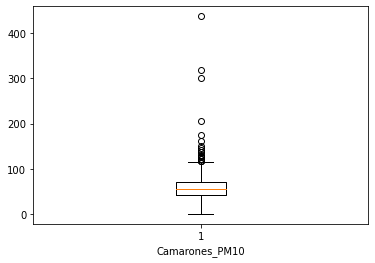

In [15]:
contaminante = "Camarones_PM10"
plt.boxplot(x=camarones_train[~camarones_train.filter(regex=contaminante, axis=1).isna().any(axis=1)][contaminante])
plt.xlabel(contaminante)
plt.show()

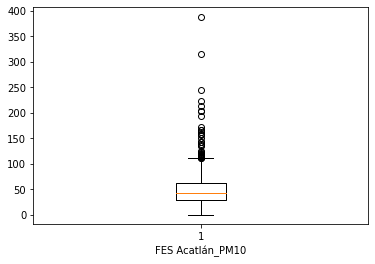

In [16]:
contaminante = "FES Acatlán_PM10"
plt.boxplot(x=camarones_train[~camarones_train.filter(regex=contaminante, axis=1).isna().any(axis=1)][contaminante])
plt.xlabel(contaminante)
plt.show()

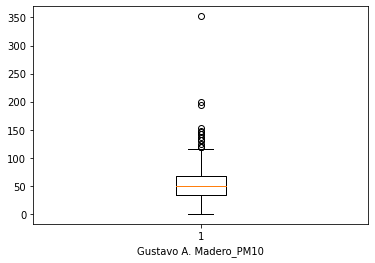

In [17]:
contaminante = "Gustavo A. Madero_PM10"
plt.boxplot(x=camarones_train[~camarones_train.filter(regex=contaminante, axis=1).isna().any(axis=1)][contaminante])
plt.xlabel(contaminante)
plt.show()

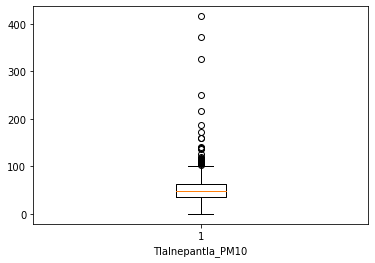

In [18]:
contaminante = "Tlalnepantla_PM10"
plt.boxplot(x=camarones_train[~camarones_train.filter(regex=contaminante, axis=1).isna().any(axis=1)][contaminante])
plt.xlabel(contaminante)
plt.show()

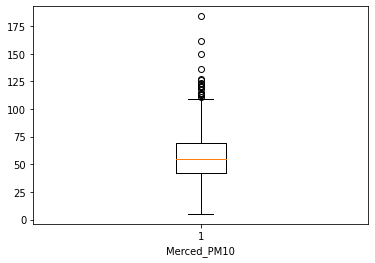

In [19]:
contaminante = "Merced_PM10"
plt.boxplot(x=camarones_train[~camarones_train.filter(regex=contaminante, axis=1).isna().any(axis=1)][contaminante])
plt.xlabel(contaminante)
plt.show()

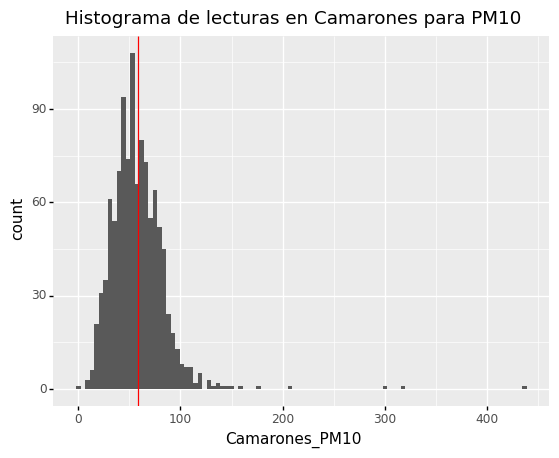

<ggplot: (8727145245641)>

In [20]:
(
    ggplot(camarones_train[["Camarones_PM10"]]) +
    geom_histogram(aes(x="Camarones_PM10"), bins=100) +
    geom_vline(aes(xintercept=camarones_train["Camarones_PM10"].mean()), 
                   color="red") +
    labs(title="Histograma de lecturas en Camarones para PM10")
)

/home/jaa6766/.conda/envs/cuda/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 63 rows containing non-finite values.


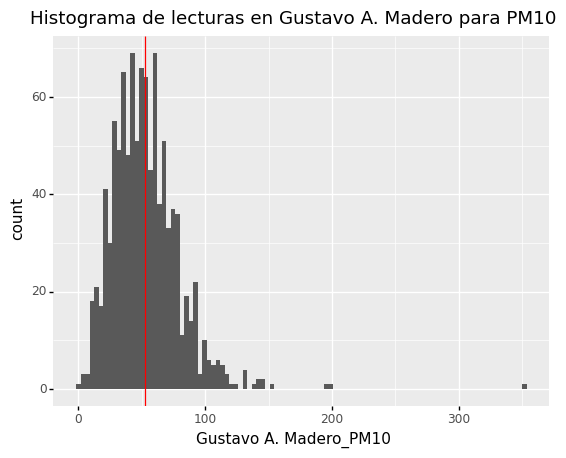

<ggplot: (8727145247413)>

In [21]:
(
    ggplot(camarones_train[["Gustavo A. Madero_PM10"]]) +
    geom_histogram(aes(x="Gustavo A. Madero_PM10"), bins=100) +
    geom_vline(aes(xintercept=camarones_train["Gustavo A. Madero_PM10"].mean()), 
                   color="red") +
    labs(title="Histograma de lecturas en Gustavo A. Madero para PM10")
)

/home/jaa6766/.conda/envs/cuda/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 8 rows containing non-finite values.


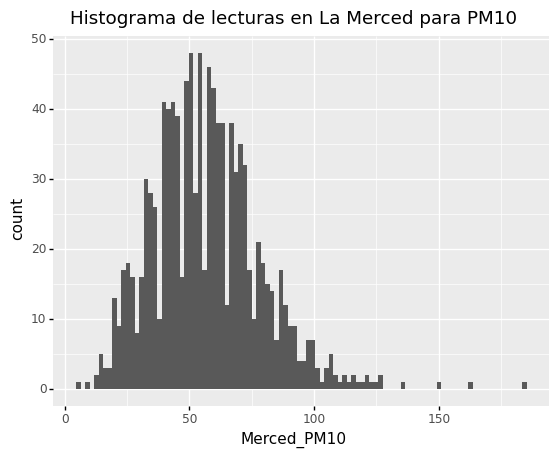

<ggplot: (8727145174981)>

In [22]:
(
    ggplot(camarones_train[["Merced_PM10"]]) +
    geom_histogram(aes(x="Merced_PM10"), bins=100) +
    labs(title="Histograma de lecturas en La Merced para PM10")
)

/home/jaa6766/.conda/envs/cuda/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 85 rows containing non-finite values.


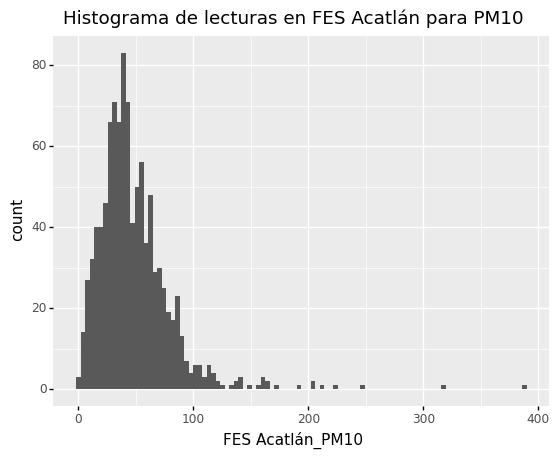

<ggplot: (8727144134965)>

In [23]:
(
    ggplot(camarones_train[["FES Acatlán_PM10"]]) +
    geom_histogram(aes(x="FES Acatlán_PM10"), bins=100) +
    labs(title="Histograma de lecturas en FES Acatlán para PM10")
)

/home/jaa6766/.conda/envs/cuda/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 58 rows containing non-finite values.


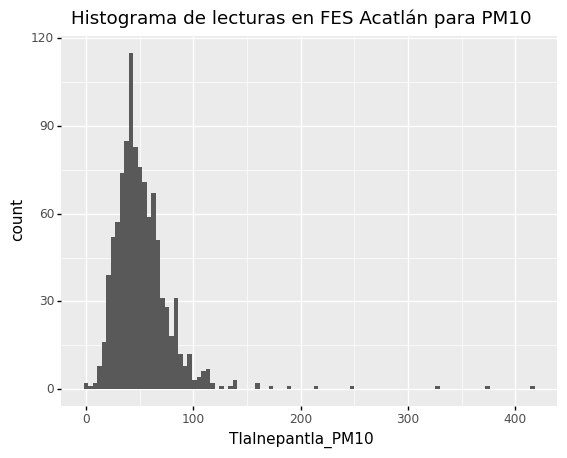

<ggplot: (8727138046765)>

In [24]:
(
    ggplot(camarones_train[["Tlalnepantla_PM10"]]) +
    geom_histogram(aes(x="Tlalnepantla_PM10"), bins=100) +
    labs(title="Histograma de lecturas en FES Acatlán para PM10")
)

#### Cruce

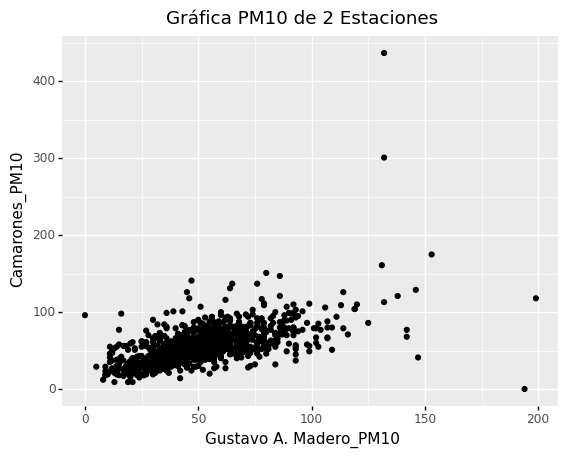

<ggplot: (8727138139285)>

In [25]:
(
    ggplot(camarones_train[~camarones_train.filter(regex=r"PM10", axis=1).isna().any(axis=1)]) +
    geom_point(aes(x="Gustavo A. Madero_PM10", y="Camarones_PM10")) +
    labs(title="Gráfica PM10 de 2 Estaciones")
)

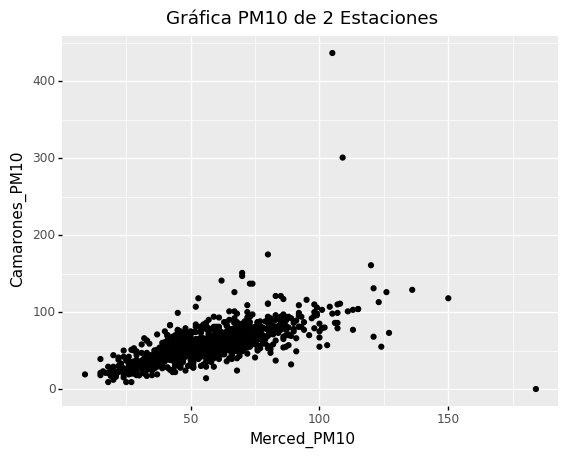

<ggplot: (8727138019421)>

In [26]:
(
    ggplot(camarones_train[~camarones_train.filter(regex=r"PM10", axis=1).isna().any(axis=1)]) +
    geom_point(aes(x="Merced_PM10", y="Camarones_PM10")) +
    labs(title="Gráfica PM10 de 2 Estaciones")
)

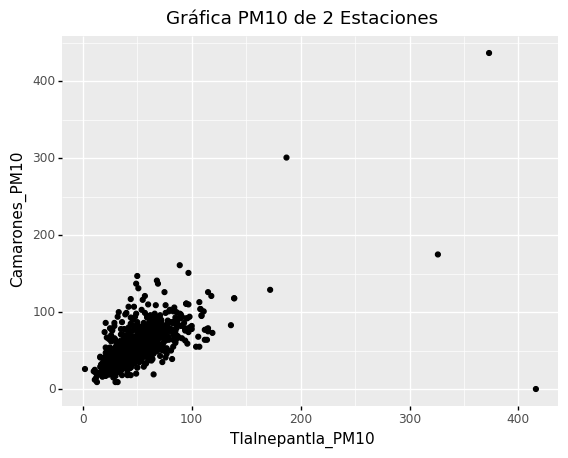

<ggplot: (8727137957793)>

In [27]:
(
    ggplot(camarones_train[~camarones_train.filter(regex=r"PM10", axis=1).isna().any(axis=1)]) +
    geom_point(aes(x="Tlalnepantla_PM10", y="Camarones_PM10")) +
    labs(title="Gráfica PM10 de 2 Estaciones")
)

In [28]:
corr = camarones_train.filter(like="PM10", axis=1)[~camarones_train.filter(regex=r"PM10", axis=1).isna().any(axis=1)].corr()
corr

,Camarones_PM10,FES Acatlán_PM10,Gustavo A. Madero_PM10,Merced_PM10,Tlalnepantla_PM10
Camarones_PM10,1.000000,0.585749,0.576044,0.644909,0.636219
FES Acatlán_PM10,0.585749,1.000000,0.561326,0.595378,0.755438
Gustavo A. Madero_PM10,0.576044,0.561326,1.000000,0.781552,0.588582
Merced_PM10,0.644909,0.595378,0.781552,1.000000,0.599567
Tlalnepantla_PM10,0.636219,0.755438,0.588582,0.599567,1.000000


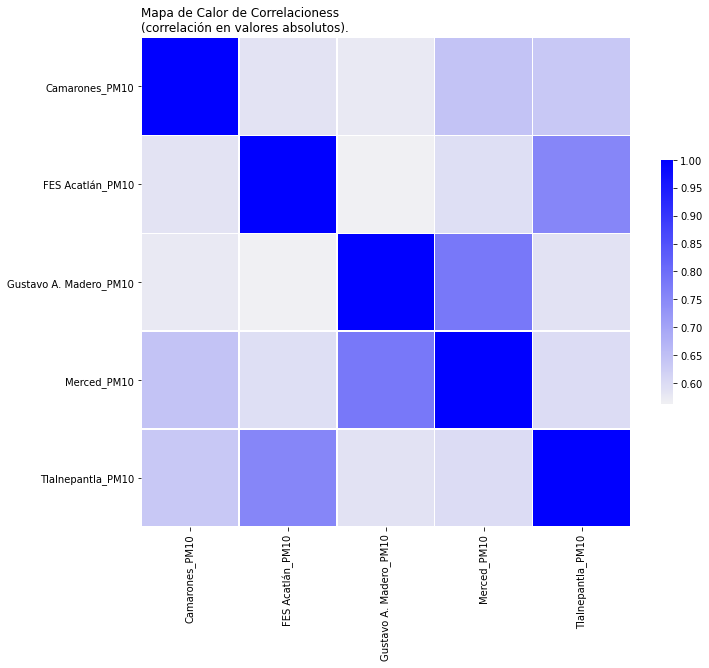

In [29]:
#corr = corr.loc[:, ["PM2.5", "PM10"]]
mask = None
#mask = np.triu(np.ones_like(corr*-1, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.palettes.blend_palette(["#ffffff", "#000055"], 
#                                  n_colors=16, 
#                                  as_cmap=True)
cmap = sns.color_palette("light:blue", as_cmap=True)

plt.title("Mapa de Calor de Correlacioness\n" +
          "(correlación en valores absolutos).", loc='left')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, #vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#plt.xlabel("Variables Respuesta")
#plt.ylabel("Variables Predictoras")
plt.show()

In [30]:
corr = camarones_train.filter(like="Camarones", axis=1)[~camarones_train.filter(regex=r"Camarones", axis=1).isna().any(axis=1)].corr()
corr

,Camarones_CO,Camarones_NO,Camarones_NO2,Camarones_NOx,Camarones_O3,Camarones_PM10,Camarones_PM2.5,Camarones_SO2
Camarones_CO,1.000000,0.743399,0.770512,0.840918,-0.452770,0.298775,0.424494,0.103995
Camarones_NO,0.743399,1.000000,0.452126,0.968873,-0.430920,0.123757,0.202277,0.102433
Camarones_NO2,0.770512,0.452126,1.000000,0.658736,-0.557640,0.283317,0.434776,0.160174
Camarones_NOx,0.840918,0.968873,0.658736,1.000000,-0.517954,0.183213,0.291152,0.130837
Camarones_O3,-0.452770,-0.430920,-0.557640,-0.517954,1.000000,0.030740,0.005117,-0.194188
Camarones_PM10,0.298775,0.123757,0.283317,0.183213,0.030740,1.000000,0.612167,0.153458
Camarones_PM2.5,0.424494,0.202277,0.434776,0.291152,0.005117,0.612167,1.000000,0.290375
Camarones_SO2,0.103995,0.102433,0.160174,0.130837,-0.194188,0.153458,0.290375,1.000000


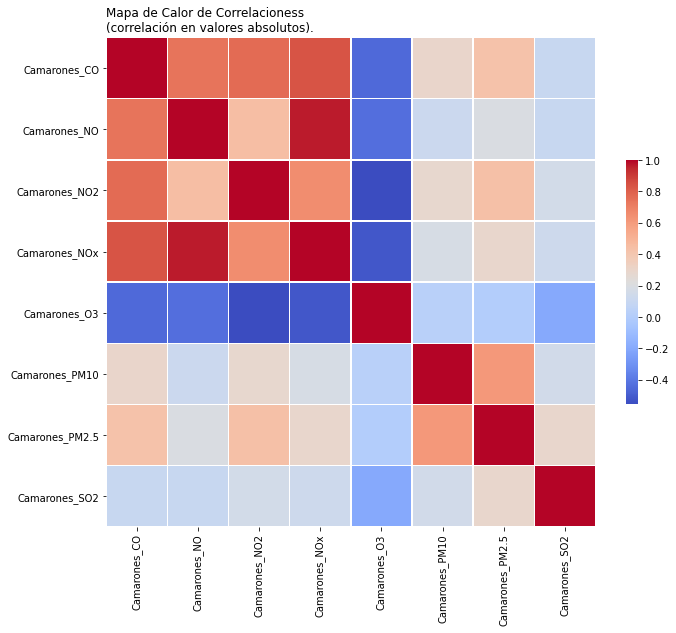

In [31]:
#corr = corr.loc[:, ["PM2.5", "PM10"]]
mask = None
#mask = np.triu(np.ones_like(corr*-1, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.palettes.blend_palette(["#ffffff", "#000055"], 
#                                  n_colors=16, 
#                                  as_cmap=True)
#cmap = sns.diverging_palette(250, 20, as_cmap=True)
cmap = sns.color_palette("coolwarm", as_cmap=True)

plt.title("Mapa de Calor de Correlacioness\n" +
          "(correlación en valores absolutos).", loc='left')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, #vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#plt.xlabel("Variables Respuesta")
#plt.ylabel("Variables Predictoras")
plt.show()

#### PM2.5

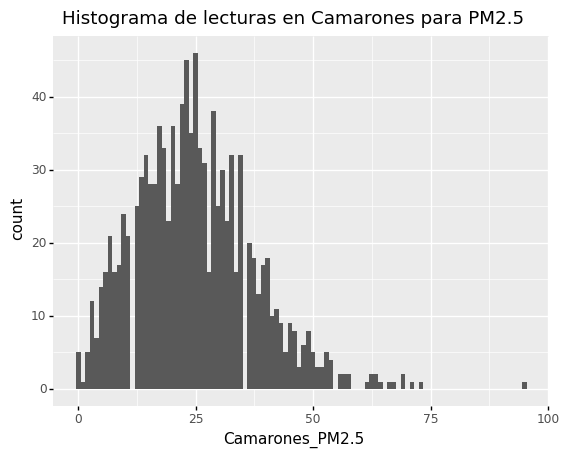

<ggplot: (8727145247469)>

In [32]:
(
    ggplot(camarones_train[["Camarones_PM2.5"]]) +
    geom_histogram(aes(x="Camarones_PM2.5"), bins=100) +
    labs(title="Histograma de lecturas en Camarones para PM2.5")
)

## Regresión Lineal

Removemos observaciones incompletas para realizar la regresión.

In [33]:
Y_train = camarones_train["Camarones_PM10"]
Y_test  = camarones_test["Camarones_PM10"]
X_train = camarones_train.filter(regex=r"^(?!Camarones_PM10|Fecha)", axis=1)
X_test = camarones_test.filter(regex=r"^(?!Camarones_PM10|Fecha)", axis=1)

X_train = camarones_train.filter(regex="(Merced|Tlalnepantla)")
X_test  = camarones_test.filter(regex="(Merced|Tlalnepantla)")

## guardar los parquet para correr Stan en R
camarones_train.to_parquet("data/camarones_train.parquet")
camarones_test.to_parquet("data/camarones_test.parquet")

### Código para filtrar solo las columnas con PM10
### Es decir, estaciones que tienen el contaminante PM10
X_test = X_test.filter(regex=r"PM10", axis=1)
X_train = X_train.filter(regex=r"PM10", axis=1)

## Removemos observaciones incompletas
X_train = X_train[~camarones_train.filter(regex=r"PM10", axis=1).isna().any(axis=1)]
X_test = X_test[~camarones_test.filter(regex=r"PM10", axis=1).isna().any(axis=1)]
Y_train = Y_train[~camarones_train.filter(regex=r"PM10", axis=1).isna().any(axis=1)]
Y_test = Y_test[~camarones_test.filter(regex=r"PM10", axis=1).isna().any(axis=1)]

In [34]:
reg = LinearRegression(n_jobs=8).fit(X_train, Y_train)
Yhat_train_lin = reg.predict(X_train)
Yhat_test_lin = reg.predict(X_test)

In [35]:
X_train.columns

Index(['Merced_PM10', 'Tlalnepantla_PM10'], dtype='object')

In [36]:
reg.coef_

array([0.53072702, 0.37388491])

In [37]:
reg.intercept_

8.488947860546723

In [38]:
r2_score(Y_train, Yhat_train_lin)

0.5131358450122813

In [39]:
r2_score(Y_test, Yhat_test_lin)

-0.4144452395742104

In [40]:
mean_squared_error(Y_train, Yhat_train_lin)

374.41392923127256

In [41]:
mean_squared_error(Y_test, Yhat_test_lin)

858.5768327522378

In [42]:
mean_absolute_error(Y_train, Yhat_train_lin)

10.999394181631775

In [43]:
mean_absolute_error(Y_test, Yhat_test_lin)

13.10422582517235

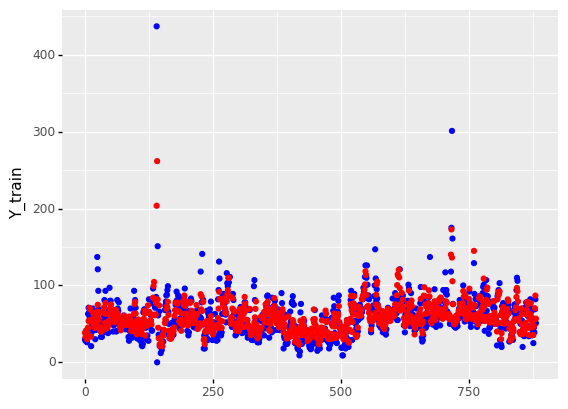

<ggplot: (8727144258929)>

In [44]:
(
    ggplot(pd.DataFrame({
        "Y_train": Y_train,
        "Yhat_train": Yhat_train_lin
    })) +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Y_train"), color='blue') +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Yhat_train"), color='red')
)

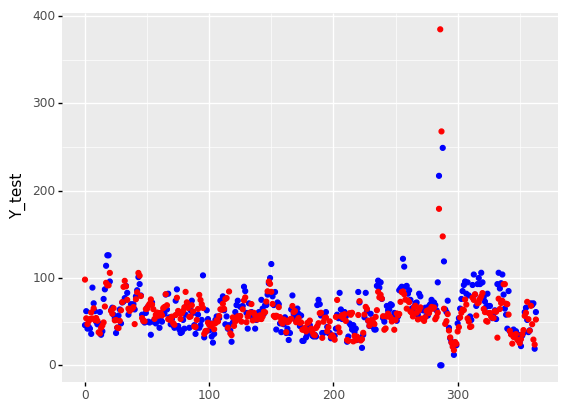

<ggplot: (8727145322917)>

In [45]:
(
    ggplot(pd.DataFrame({
        "Y_test": Y_test,
        "Yhat_test": Yhat_test_lin
    })) +
    geom_point(aes(x=range(0, Y_test.shape[0]), y="Y_test"), color='blue') +
    geom_point(aes(x=range(0, Y_test.shape[0]), y="Yhat_test"), color='red')
)

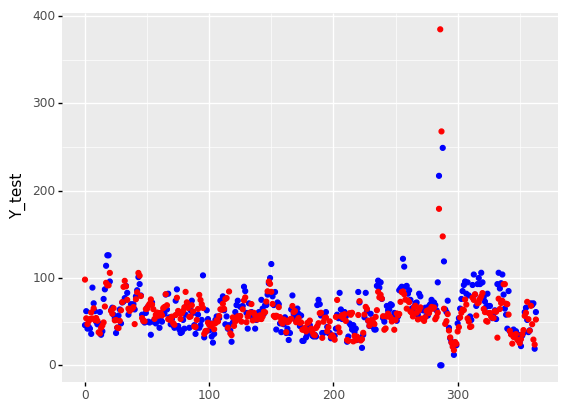

<ggplot: (8727144168745)>

In [46]:
(
    ggplot(pd.DataFrame({
        "Y_test": Y_test,
        "Yhat_test": Yhat_test_lin
    })) +
    geom_point(aes(x=range(0, Y_test.shape[0]), y="Y_test"), color='blue') +
    geom_point(aes(x=range(0, Y_test.shape[0]), y="Yhat_test"), color='red')
)

## Lasso

In [47]:
Y_train = camarones_train["Camarones_PM10"]
Y_test  = camarones_test["Camarones_PM10"]
X_train = camarones_train.filter(regex=r"^(?!Camarones_PM10|Fecha)", axis=1)
X_test = camarones_test.filter(regex=r"^(?!Camarones_PM10|Fecha)", axis=1)

### Código para filtrar solo las columnas con PM10
### Es decir, estaciones que tienen el contaminante PM10
X_test = X_test.filter(regex=r"PM10", axis=1)
X_train = X_train.filter(regex=r"PM10", axis=1)

## Removemos observaciones incompletas
X_train = X_train[~camarones_train.filter(regex=r"PM10", axis=1).isna().any(axis=1)]
X_test = X_test[~camarones_test.filter(regex=r"PM10", axis=1).isna().any(axis=1)]
Y_train = Y_train[~camarones_train.filter(regex=r"PM10", axis=1).isna().any(axis=1)]
Y_test = Y_test[~camarones_test.filter(regex=r"PM10", axis=1).isna().any(axis=1)]

In [48]:
reg = Lasso().fit(X_train, Y_train)
Yhat_train_lasso = reg.predict(X_train)
Yhat_test_lasso = reg.predict(X_test)

In [49]:
X_train.columns

Index(['FES Acatlán_PM10', 'Gustavo A. Madero_PM10', 'Merced_PM10',
       'Tlalnepantla_PM10'],
      dtype='object')

In [50]:
reg.coef_

array([0.09567696, 0.06840776, 0.4426    , 0.29441044])

In [51]:
reg.intercept_

9.366559256014888

In [52]:
r2_score(Y_train, Yhat_train_lasso)

0.5199968593721296

In [53]:
r2_score(Y_test, Yhat_test_lasso)

-0.1294304409086644

In [54]:
mean_squared_error(Y_train, Yhat_train_lasso)

369.1375922517144

In [55]:
mean_squared_error(Y_test, Yhat_test_lasso)

685.5711226128724

In [56]:
mean_absolute_error(Y_train, Yhat_train_lasso)

10.90154265031963

In [57]:
mean_absolute_error(Y_test, Yhat_test_lasso)

12.558248813984083

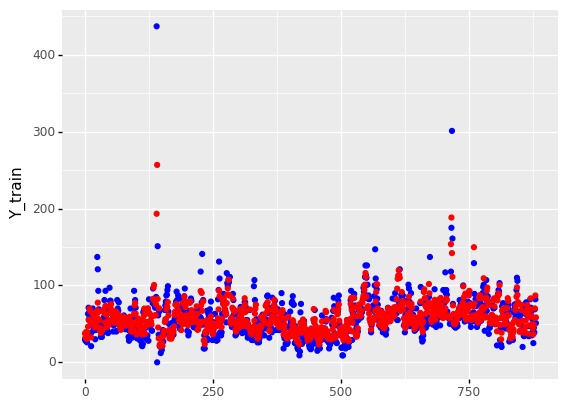

<ggplot: (8727145426093)>

In [58]:
(
    ggplot(pd.DataFrame({
        "Y_train": Y_train,
        "Yhat_train": Yhat_train_lasso
    })) +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Y_train"), color='blue') +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Yhat_train"), color='red')
)

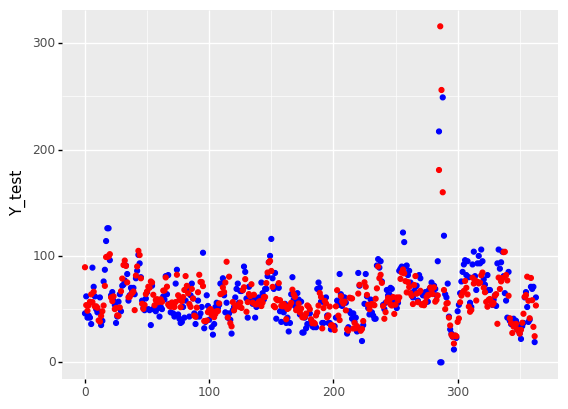

<ggplot: (8727145349429)>

In [59]:
(
    ggplot(pd.DataFrame({
        "Y_test": Y_test,
        "Yhat_test": Yhat_test_lasso
    })) +
    geom_point(aes(x=range(0, Y_test.shape[0]), y="Y_test"), color='blue') +
    geom_point(aes(x=range(0, Y_test.shape[0]), y="Yhat_test"), color='red')
)

## Regresión Lineal Bayesiana

Se utilizó Stan para realizar una aproximación de los datos que se distribuyen similar a una Poisson.

In [60]:
Yhat_train_stan = pd.read_parquet("data/camarones_train_yhat-stan.parquet")
Yhat_train_stan = Yhat_train_stan["mean-all chains"]
Yhat_test_stan = pd.read_parquet("data/camarones_test_yhat-stan.parquet")
Yhat_test_stan = Yhat_test_stan["mean-all chains"]
Yhat_train_stan.shape[0]

882

In [61]:
Y_train.shape[0]

882

In [62]:
Y_test.shape, Yhat_test_stan.shape

((364,), (414,))

In [63]:
r2_score(Y_train, Yhat_train_stan)

0.22337355392189118

In [64]:
mean_squared_error(Y_train, Yhat_train_stan)

597.2502930070067

In [65]:
mean_absolute_error(Y_train, Yhat_train_stan)

12.397323356009071

In [66]:
df = pd.DataFrame({
        "Y_test": Y_test.reset_index(drop=True),
        "Yhat_test": Yhat_test_stan
    })
df = df[~df.isnull().any(axis=1)]
mean_absolute_error(df[["Y_test"]], df[["Yhat_test"]])

49.862637362637365

In [67]:
gdf = pd.concat({
        "Y_train": Y_train.reset_index(drop=True),
        "Yhat_train": Yhat_train_stan
    }, axis=1)[["Y_train", "Yhat_train"]]

gdf

,Y_train,Yhat_train
0,30.0,42.5550
1,28.0,39.7008
2,38.0,43.0379
3,35.0,40.4369
4,26.0,38.4014
...,...,...
877,45.0,52.5123
878,39.0,58.2521
879,69.0,70.1079
880,82.0,81.5443


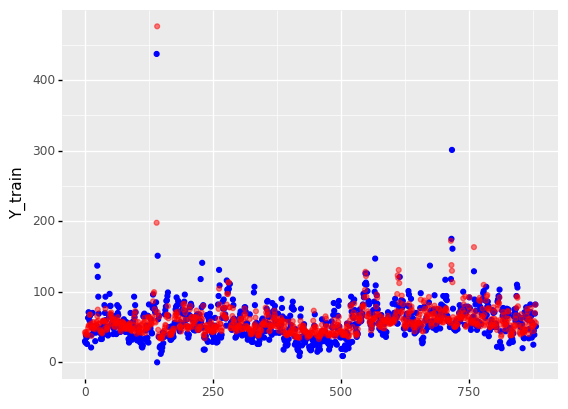

<ggplot: (8727145137205)>

In [68]:
(
    ggplot(pd.DataFrame({
        "Y_train": Y_train.reset_index(drop=True),
        "Yhat_train": Yhat_train_stan
    })) +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Y_train"), 
               color='blue') +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Yhat_train"), 
               color='red', alpha=.5) 
)

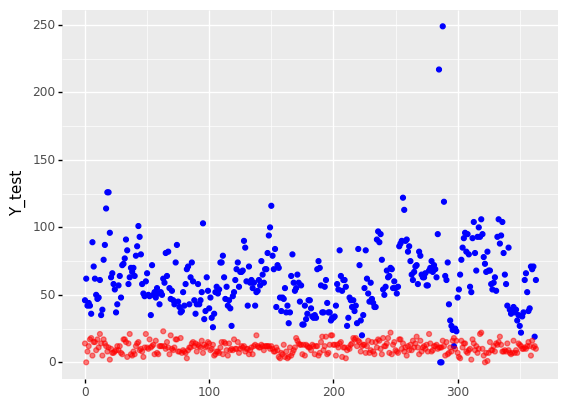

<ggplot: (8727145402101)>

In [69]:
df = pd.DataFrame({
        "Y_test": Y_test.reset_index(drop=True),
        "Yhat_test": Yhat_test_stan
    })
df = df[~df.isnull().any(axis=1)]

(
    ggplot(df) +
    geom_point(aes(x=range(0, df.shape[0]), y="Y_test"), 
               color='blue') +
    geom_point(aes(x=range(0, df.shape[0]), y="Yhat_test"), 
               color='red', alpha=.5) 
)

## Media

In [70]:
Yhat_train_mean = X_train.mean(axis=1)
Yhat_test_mean = X_test.mean(axis=1)

In [71]:
mean_squared_error(Y_train, Yhat_train_mean)

425.91850907029476

In [72]:
mean_squared_error(Y_test, Yhat_test_mean)

581.5554601648352

In [73]:
mean_absolute_error(Y_train, Yhat_train_mean)

12.331632653061224

In [74]:
mean_absolute_error(Y_test, Yhat_test_mean)

13.761675824175825

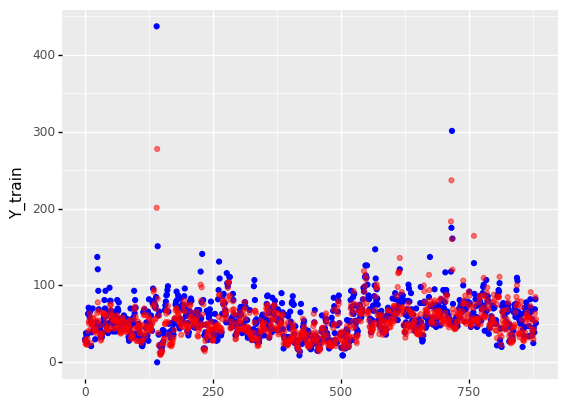

<ggplot: (8727144410913)>

In [75]:
(
    ggplot(pd.DataFrame({
        "Y_train": Y_train,
        "Yhat_train": Yhat_train_mean
    })) +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Y_train"), 
               color='blue') +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Yhat_train"), 
               color='red', alpha=.5) 
)

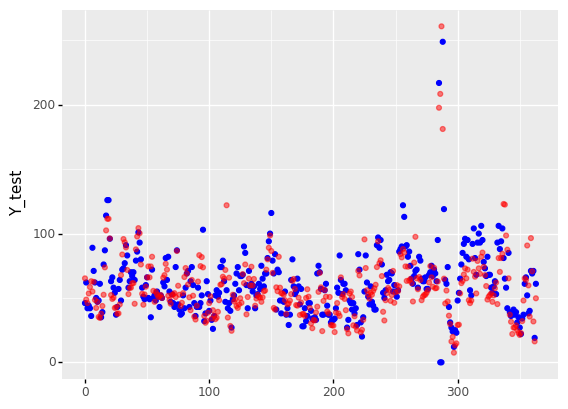

<ggplot: (8727145321477)>

In [76]:
(
    ggplot(pd.DataFrame({
        "Y_train": Y_test,
        "Yhat_train": Yhat_test_mean
    })) +
    geom_point(aes(x=range(0, Y_test.shape[0]), y="Y_test"), 
               color='blue') +
    geom_point(aes(x=range(0, Y_test.shape[0]), y="Yhat_train"), 
               color='red', alpha=.5) 
)

## Modelos Generalizados de Regresión (GLM)



In [77]:
from sklearn.linear_model import PoissonRegressor
reg = PoissonRegressor(alpha=1e3)
reg_fit = reg.fit(X_train, Y_train)

In [78]:
Yhat_train_glm = reg_fit.predict(X_train)
(Yhat_train_glm.shape, Y_train.shape)

((882,), (882,))

In [79]:
Yhat_test_glm = reg_fit.predict(X_test)
(Yhat_test_glm.shape, Y_test.shape)

((364,), (364,))

In [80]:
mean_squared_error(Yhat_train_glm
                   , Y_train)

574.6123333889531

In [81]:
mean_squared_error(Yhat_test_glm, Y_test)

8981.353126604927

In [82]:
mean_absolute_error(Yhat_train_glm, Y_train)

12.397197210039439

In [83]:
mean_absolute_error(Yhat_test_glm, Y_test)

18.54832154876485

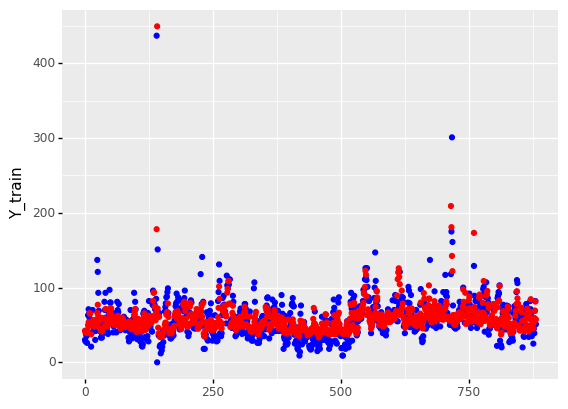

<ggplot: (8727145321513)>

In [84]:
(
    ggplot(pd.DataFrame({
        "Y_train": Y_train.reset_index(drop=True),
        "Yhat_train": Yhat_train_glm
    })) +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Y_train"), color='blue') +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Yhat_train"), color='red')
)

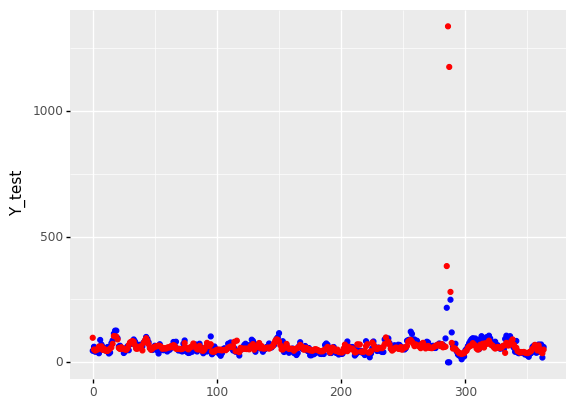

<ggplot: (8727144710821)>

In [85]:
(
    ggplot(pd.DataFrame({
        "Y_test": Y_test,
        "Yhat_test": Yhat_test_glm
    })) +
    geom_point(aes(x=range(0, Y_test.shape[0]), y="Y_test"), color='blue') +
    geom_point(aes(x=range(0, Y_test.shape[0]), y="Yhat_test"), color='red')
)

## K-Nearest Neighbors


In [86]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=20, p=1)
knn_fit = knn.fit(X_train, Y_train)

In [87]:
Yhat_train_knn = knn_fit.predict(X_train)
(Yhat_train_knn.shape, Y_train.shape)

((882,), (882,))

In [88]:
Yhat_test_knn = knn_fit.predict(X_test)
(Yhat_test_knn.shape, Y_test.shape)

((364,), (364,))

In [89]:
mean_squared_error(Yhat_train_knn,
                   Y_train)

350.21837018140593

In [90]:
mean_squared_error(Yhat_test_knn, Y_test)

330.019271978022

In [91]:
mean_absolute_error(Yhat_train_knn, Y_train)

10.843934240362811

In [92]:
mean_absolute_error(Yhat_test_knn, Y_test)

11.718681318681318

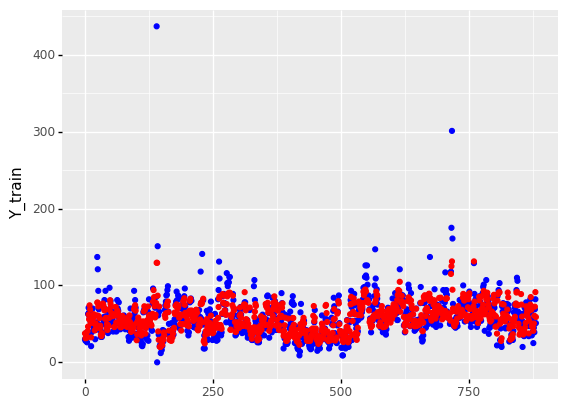

<ggplot: (8727145010693)>

In [93]:
(
    ggplot(pd.DataFrame({
        "Y_train": Y_train.reset_index(drop=True),
        "Yhat_train": Yhat_train_knn
    })) +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Y_train"), color='blue') +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Yhat_train"), color='red')
)

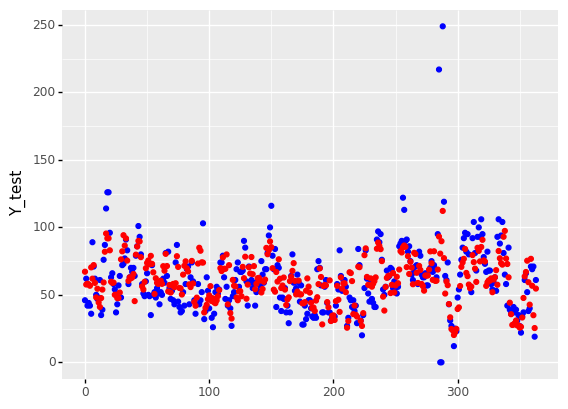

<ggplot: (8727145068541)>

In [94]:
(
    ggplot(pd.DataFrame({
        "Y_test": Y_test,
        "Yhat_test": Yhat_test_knn
    })) +
    geom_point(aes(x=range(0, Y_test.shape[0]), y="Y_test"), color='blue') +
    geom_point(aes(x=range(0, Y_test.shape[0]), y="Yhat_test"), color='red')
)

## Evaluación

In [95]:
df = pd.DataFrame({
        "Y_test": Y_test.reset_index(drop=True),
        "Yhat_test": Yhat_test_stan
    })
df = df[~df.isnull().any(axis=1)]
df2 = pd.DataFrame({
    "Model": [
        "1.2 Regresión Lineal",
        "1.3 Lasso",
        "1.4 Stan",
        "1.5 Media",
        "1.6 GLM",
        "1.7 KNN"
    ],
    "MSE (Train Set)": [
        mean_squared_error(Y_train, Yhat_train_lin),
        mean_squared_error(Y_train, Yhat_train_lasso),
        mean_squared_error(Y_train, Yhat_train_stan),
        mean_squared_error(Y_train, Yhat_train_mean),
        mean_squared_error(Y_train, Yhat_train_glm),
        mean_squared_error(Y_train, Yhat_train_knn),
    ],
    "MAE (Train Set)": [
        mean_absolute_error(Y_train, Yhat_train_lin),
        mean_absolute_error(Y_train, Yhat_train_lasso),
        mean_absolute_error(Y_train, Yhat_train_stan),
        mean_absolute_error(Y_train, Yhat_train_mean),
        mean_absolute_error(Y_train, Yhat_train_glm),
        mean_absolute_error(Y_train, Yhat_train_knn),
    ],
    "MSE (Test Set)": [
        mean_squared_error(Y_test, Yhat_test_lin),
        mean_squared_error(Y_test, Yhat_test_lasso),
        mean_squared_error(df[["Y_test"]], df[["Yhat_test"]]),
        mean_squared_error(Y_test, Yhat_test_mean),
        mean_squared_error(Y_test, Yhat_test_glm),
        mean_squared_error(Y_test, Yhat_test_knn),
    ],
    "MAE (Test Set)": [
        mean_absolute_error(Y_test, Yhat_test_lin),
        mean_absolute_error(Y_test, Yhat_test_lasso),
        mean_absolute_error(df[["Y_test"]], df[["Yhat_test"]]),
        mean_absolute_error(Y_test, Yhat_test_mean),
        mean_absolute_error(Y_test, Yhat_test_glm),
        mean_absolute_error(Y_test, Yhat_test_knn),
    ]
    })
df2.sort_values(by="MSE (Test Set)")

,Model,MSE (Train Set),MAE (Train Set),MSE (Test Set),MAE (Test Set)
5,1.7 KNN,350.218370,10.843934,330.019272,11.718681
3,1.5 Media,425.918509,12.331633,581.555460,13.761676
1,1.3 Lasso,369.137592,10.901543,685.571123,12.558249
0,1.2 Regresión Lineal,374.413929,10.999394,858.576833,13.104226
2,1.4 Stan,597.250293,12.397323,3087.945055,49.862637
4,1.6 GLM,574.612333,12.397197,8981.353127,18.548322


## Conclusiones

El mejor modelo fue el de K Vecinos más Cercanos. Por lo que consideraremos incluirlo como imputación para el modelo con las estaciones de monitoreo de contaminantes de la Ciudad de México.

## Referencias

* <https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-regression>

* <https://pythonhealthcare.org/2018/05/03/81-distribution-fitting-to-data/>

* <https://medium.com/@amirarsalan.rajabi/distribution-fitting-with-python-scipy-bb70a42c0aed>

* <https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html?highlight=kernel%20density#sklearn.neighbors.KernelDensity>